<a href="https://colab.research.google.com/github/Remil-Maha/100DaysOfCUDA/blob/main/Day02_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Day 2 – Julia Set Visualization Using CUDA

#### Goal : The goal of Day 2 is to generate and visualize a Julia Set fractal using CUDA.

### What I did:

* Implemented a CUDA kernel (__global__) to compute the Julia Set directly on the GPU.
* Assigned one CUDA thread to each pixel of the image using a 2D grid and block structure.
* Used blockIdx and gridDim to calculate the unique thread ID or offset  for each pixel.
* Wrote pixel color values (RGBA) into a shared memory buffer that was passed to the GPU.
* Called a CPU display function (bitmap.display_and_exit()) to render the result.

In [1]:
# Affiche l’état actuel du GPU NVIDIA, y compris l’utilisation de la mémoire, les processus en cours, la température, la version du pilote et la version de CUDA.
!nvidia-smi

Mon Aug  4 16:43:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-in1cs8et
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-in1cs8et
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10742 sha256=fdb30b442a03a2b978d94f242f4f3839c3b517111d4c5bcc31496f40b5aacbba
  Stored in directory: /tmp/pip-ephem-wheel-cache-6856al96/wheels/ef/1d/c6/f7e47f1aa1bc9d05c4120d94f90a79cf28603ef343b0dd43ff
Successfully built nvcc4jupyter


In [12]:
%%writefile julia_set.cu

#include <stdio.h>
#include <sys/time.h>
#include <cuda.h>
#include <cuda_runtime.h>

/*****************************************************Implementation de la classe Bitmap****************************************************************/

// cpu_bitmap.h
#ifndef CPU_BITMAP_H
#define CPU_BITMAP_H

#include <cstdio>
#include <cstdlib>
#include <cstring>

class CPUBitmap {
private:
    int width, height;
    unsigned char* pixels;

public:
    CPUBitmap(int w, int h) : width(w), height(h) {
        pixels = new unsigned char[width * height * 4]; // RGBA = 4 bytes/pixel
        memset(pixels, 0, width * height * 4);
    }

    ~CPUBitmap() {
        delete[] pixels;
    }

    unsigned char* get_ptr() {
        return pixels;
    }

    int image_size() const {
        return width * height * 4;
    }

    void display_and_exit(const char* filename = "julia_output.ppm") {
        // Sauvegarde au format PPM (Portable Pixmap Format)
        FILE* f = fopen(filename, "wb");
        if (!f) {
            fprintf(stderr, "Erreur: impossible de créer %s\n", filename);
            exit(1);
        }

        fprintf(f, "P6\n%d %d\n255\n", width, height);
        for (int i = 0; i < width * height; ++i) {
            // On ignore l’alpha ici, on écrit seulement RGB
            fwrite(&pixels[i * 4 + 0], 1, 1, f); // R
            fwrite(&pixels[i * 4 + 1], 1, 1, f); // G
            fwrite(&pixels[i * 4 + 2], 1, 1, f); // B
        }

        fclose(f);
        printf("Image enregistrée dans le fichier %s\n", filename);
        exit(0);
    }
};

#endif


/**********************************************************************CUDA***************************************************************/

#define DIM 100


struct cuComplex{
  float r;
  float i;
  __device__ cuComplex(float a, float b) : r(a)  , i(b){} // constructor
  __device__ float magnitude2( void ){
     return r*r+i*i;
     }
  __device__ cuComplex operator* (const cuComplex& b) const {
    return cuComplex(r*b.r-i*b.i, r*b.i+i*b.r);
  }
  __device__ cuComplex operator+(const cuComplex& a) {
 return cuComplex(r+a.r, i+a.i);
    }
  };
  // Note : cuComplex is structure that represents a complex number where r is the real part and i is the imaginary part.
  // real part and i the imaginary one  , so if we have for example : cuComplex(3.f ,4.f)
  // == 3+4i

__device__ int Julia (int x , int y ){
    const float scale = 1.5;
    float jx = scale *(float)(DIM/2-x)/(DIM/2);
    float jy = scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(-0.8,0.156);
    cuComplex a(jx,jy);

    int i = 0 ;
    for (i= 0  ; i< 200 ; i++){
      a = a * a + c ;
      if (a.magnitude2()> 1000)
         return 0;
    }
    return 1;
}
__global__ void kernel (unsigned char *ptr){
  // in this approach we are going to transform our image (whiich is as a matrix
  //) to a 1D vector
  //Note that : in Cuda if we have for example dim3 grid_size(3,2) that means
  // that we have 3 colons and 2 lines
  // in our code we are going to assign every pixel to a block and since a block
  // has 1 thread  , so each thread has a pixel

  int tid = blockIdx.x + blockIdx.y * gridDim.x;

  int Julia_value = Julia(x , y);
  ptr[tid *4 + 0] = Julia_value * 255;
  ptr[tid *4 + 1] = 0;
  ptr[tid *4 + 2] = 0;
  ptr[tid *4+ 3] = Julia_value * 255;
  // we are going to color it in red = {255,0,0,255}
  // note that every pixel is in 4 bytes .
}


int main() {
    CPUBitmap bitmap(DIM, DIM);
    unsigned char *dev_bitmap;

    cudaMalloc((void**)&dev_bitmap , bitmap.image_size());
    dim3 grid(DIM , DIM);
    kernel <<<grid, 1>>> (dev_bitmap);


    cudaMemcpy(bitmap.get_ptr(), dev_bitmap, bitmap.image_size(), cudaMemcpyDeviceToHost);

    bitmap.display_and_exit();

    cudaFree(dev_bitmap);
    return 0;
}



Overwriting julia_set.cu


In [13]:
# Compile the CUDA code using NVIDIA's compiler (nvcc)
# This creates an executable named 'vector_addition'
!nvcc -arch=sm_75 julia_set.cu -o julia_set


In [14]:
# Run the executable that performs vector addition on the GPU
!./julia_set

Image enregistrée dans le fichier julia_output.ppm


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

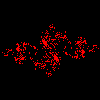

In [17]:
from IPython.display import Image, display
import shutil

# Convertir le fichier PPM en PNG pour affichage (facultatif mais plus propre)
!apt install imagemagick -y
!convert julia_output.ppm julia_output.png

# Affichage
display(Image(filename='julia_output.png'))
